In [1]:
#General DS imports
import pandas as pd
import numpy as np

#Stats
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression 
from math import sqrt

#Visualizations
import seaborn as sns
import matplotlib.pyplot as plt

#warnings
import warnings
warnings.filterwarnings('ignore')

#My files
import env
import wrangle as w
import model as m
import explore as ex

### 1. Load your zillow dataset.

In [2]:
#Get Zillow Data
df = w.get_zillow_data()

In [3]:
df.head(2)

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,0.0,0.0,NaN,10.0,NaN,NaN,6037.0


In [4]:
#Clean Zillow Data
df = w.clean_zillow(df)

In [5]:
df.head(2)

,bedrooms,bathrooms,square_feet,tax_value,year_built,tax_amount,fips,county,home_age
4,4,2.0,3633,296425,2005,6941.39,6037,Los Angeles,12
6,3,4.0,1620,847770,2011,10244.94,6037,Los Angeles,6


In [6]:
#Remove Outliers
df = w.remove_outliers(df, ['bedrooms','bathrooms','square_feet','tax_value','tax_amount'])

In [7]:
df.head(2)

,bedrooms,bathrooms,square_feet,tax_value,year_built,tax_amount,fips,county,home_age
6,3,4.0,1620,847770,2011,10244.94,6037,Los Angeles,6
7,3,2.0,2077,646760,1926,7924.68,6037,Los Angeles,91


In [8]:
#Split data with function from wrangle
train, validate, test = w.train_validate_test_split(df)

In [9]:
train.head(2)

,bedrooms,bathrooms,square_feet,tax_value,year_built,tax_amount,fips,county,home_age
1560492,3,2.0,1284,78502,1964,743.78,6059,Orange,53
453041,4,2.0,1694,341772,1961,3609.74,6111,Ventura,56


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1297953 entries, 1560492 to 1910478
Data columns (total 9 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   bedrooms     1297953 non-null  int64  
 1   bathrooms    1297953 non-null  float64
 2   square_feet  1297953 non-null  int64  
 3   tax_value    1297953 non-null  int64  
 4   year_built   1297953 non-null  int64  
 5   tax_amount   1297953 non-null  float64
 6   fips         1297953 non-null  int64  
 7   county       1297953 non-null  object 
 8   home_age     1297953 non-null  int64  
dtypes: float64(2), int64(6), object(1)
memory usage: 99.0+ MB


### 2. Fit a linear regression model (ordinary least squares) and compute yhat, predictions of taxvaluedollarcnt using only calculatedfinishedsqft.

In [11]:
#Creating new df with just square feet and the target
zillow_lr = train[['square_feet','tax_value']].copy()

In [12]:
zillow_lr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1297953 entries, 1560492 to 1910478
Data columns (total 2 columns):
 #   Column       Non-Null Count    Dtype
---  ------       --------------    -----
 0   square_feet  1297953 non-null  int64
 1   tax_value    1297953 non-null  int64
dtypes: int64(2)
memory usage: 29.7 MB


In [13]:
#Reset index and drop old index
zillow_lr = zillow_lr.reset_index(drop=True)

In [14]:
zillow_lr.head()

,square_feet,tax_value
0,1284,78502
1,1694,341772
2,1842,648122
3,1922,219472
4,1627,69897


In [15]:
#Rename column names
zillow_lr.rename(columns = {'square_feet':'x', 'tax_value':'y'}, inplace = True)

In [16]:
zillow_lr.head(2)

,x,y
0,1284,78502
1,1694,341772


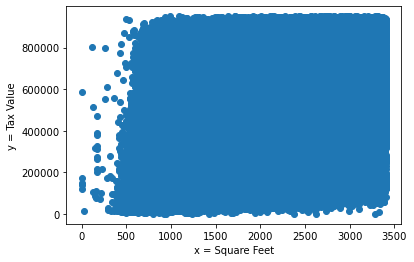

In [17]:
# Visualize with scatter plot
plt.scatter(zillow_lr.x, zillow_lr.y)

plt.xlabel('x = Square Feet')
plt.ylabel('y = Tax Value')
plt.show()

### 2. Fit a linear regression model (ordinary least squares) and compute yhat, predictions of taxvaluedollarcnt using only calculatedfinishedsqft.

In [22]:
#calculate mean (Baseline)
baseline = round(zillow_lr.y.mean())
print(f'The baseline is: {round(baseline)}')

The baseline is: 327807


In [23]:
#add it to the df
zillow_lr['baseline'] = baseline

In [24]:
zillow_lr.head(2)

,x,y,baseline
0,1284,78502,327807
1,1694,341772,327807


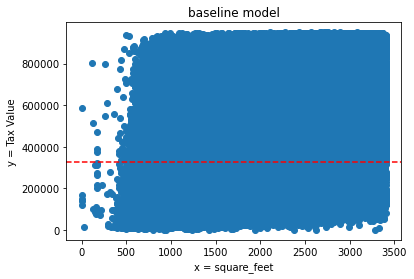

In [27]:
# plot data with baseline:
plt.scatter(zillow_lr.x, zillow_lr.y)
plt.axhline(baseline, color = "red", ls='--')

plt.xlabel('x = square_feet')
plt.ylabel('y = Tax Value')
plt.title('baseline model')
plt.show()

In [28]:
# OLS = ordinary least squares
# create the model object
lm = LinearRegression()

# fit the model to trainig data
lm.fit(zillow_lr[['x']], zillow_lr.y)

# make prediction
# lm.predict will output a numpy array of values,
# we will put those values into a series in df
zillow_lr['yhat'] = lm.predict(zillow_lr[['x']])

In [30]:
zillow_lr.head(2)

,x,y,baseline,yhat
0,1284,78502,327807,272830.565707
1,1694,341772,327807,333899.340527


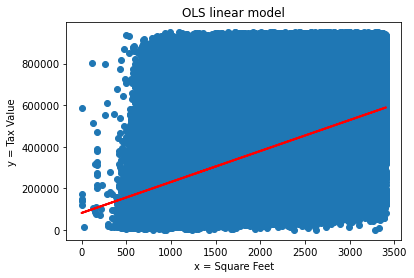

In [33]:
# visualize the line of best fit from OLS linear model

#scatter is my actuals
plt.scatter(zillow_lr.x, zillow_lr.y)

#lineplot is my regression line
plt.plot(zillow_lr.x, zillow_lr.yhat, linewidth=2, color='red')

plt.xlabel('x = Square Feet')
plt.ylabel('y = Tax Value')
plt.title('OLS linear model')
plt.show()

### 3. Plot the residuals for the linear regression model that you made.

In [34]:
# residual = actual - predicted
zillow_lr['baseline_residual'] = zillow_lr.y - zillow_lr.baseline
zillow_lr['residual'] = zillow_lr.y - zillow_lr.yhat

In [35]:
zillow_lr.head(2)

,x,y,baseline,yhat,baseline_residual,residual
0,1284,78502,327807,272830.565707,-249305,-194328.565707
1,1694,341772,327807,333899.340527,13965,7872.659473


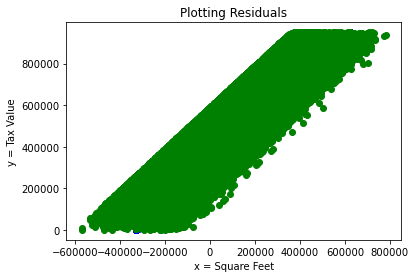

In [38]:
# visualize the residuals

#scatter
plt.scatter(zillow_lr.baseline_residual, zillow_lr.y, color='blue')
plt.scatter(zillow_lr.residual, zillow_lr.y, color = 'green')

plt.xlabel('x = Square Feet')
plt.ylabel('y = Tax Value')
plt.title('Plotting Residuals')

plt.show()

### 4. Calculate the sum of squared errors, explained sum of squares, total sum of squares, mean squared error, and root mean squared error for your model.

In [51]:
#See below

### 5. Calculate the sum of squared errors, mean squared error, and root mean squared error for the baseline model (i.e. a model that always predicts the average taxvaluedollarcnt amount).

In [40]:
#Calculating Square of the residuals
#difference between yhat and y, just squared
zillow_lr['baseline_residual_2'] = zillow_lr.baseline_residual**2
zillow_lr['residual_2'] = zillow_lr.residual**2

In [41]:
zillow_lr.head(2)

,x,y,baseline,yhat,baseline_residual,residual,baseline_residual_2,residual_2
0,1284,78502,327807,272830.565707,-249305,-194328.565707,62152983025,3.776359e+10
1,1694,341772,327807,333899.340527,13965,7872.659473,195021225,6.197877e+07


In [42]:
## Summing up residual squares
#add the residuals together
SSE_baseline = zillow_lr.baseline_residual_2.sum()
SSE = zillow_lr.residual_2.sum()
print("SSE Baseline =", "{:.1f}".format(SSE_baseline))
print('SSE =', "{:.1f}".format(SSE))

SSE Baseline = 51351540449416120.0
SSE = 42184111649643496.0


In [45]:
#calcaluate MSE
MSE_baseline = SSE_baseline/len(zillow_lr)
MSE = SSE/len(zillow_lr)
print(f"MSE baseline = {MSE_baseline:.1f}")
print(f'MSE = {MSE:.1f}')

MSE baseline = 39563482228.9
MSE = 32500492429.0


In [46]:
#calculate RMSE
RMSE_baseline = MSE_baseline**.5
RMSE = MSE**.5
print("RMSE baseline = ", "{:.1f}".format(RMSE_baseline))
print("RMSE = ", "{:.1f}".format(RMSE))

RMSE baseline =  198905.7
RMSE =  180278.9


In [48]:
#Using SK Learn to do this
MSE2_baseline = mean_squared_error(zillow_lr.y, zillow_lr.baseline)
MSE2 = mean_squared_error(zillow_lr.y, zillow_lr.yhat)
print("MSE baseline:", MSE2_baseline) 
print("MSE:", MSE2) 

MSE baseline: 39563482228.87588
MSE: 32500492428.958134


In [49]:
SSE2_baseline =  MSE2_baseline * len(zillow_lr)
SSE2 = MSE2 * len(zillow_lr)
print("SSE baseline:" ,SSE2_baseline) 
print("SSE:", SSE2) 

SSE baseline: 5.135154044941613e+16
SSE: 4.2184111649643496e+16


In [50]:
#Calculating RMSE with sklearn, using 'squared=false'
MSE2_baseline = mean_squared_error(zillow_lr.y, zillow_lr.baseline, squared=False)
MSE2 = mean_squared_error(zillow_lr.y, zillow_lr.yhat, squared=False)
print("MSE baseline:", MSE2_baseline) 
print("MSE:", MSE2) 

MSE baseline: 198905.71190610863
MSE: 180278.92952022466


### 6. Write python code that compares the sum of squared errors for your model against the sum of squared errors for the baseline model and outputs whether or not your model performs better than the baseline model.

In [56]:
SSE_difference = SSE_baseline - SSE
print(f'The difference in SSE from my model and the baseline is:{SSE_difference}')
print(f'This model performs better than the baseline')

The difference in SSE from my model and the baseline is:9167428799772624.0
This model performs better than the baseline


### 7. What is the amount of variance explained in your model?

In [57]:
#Calculating R2 Manually:
# Total Sum of Squares = SSE for baseline
TSS = SSE_baseline
# Sum of squared error for the regression line (Unexplained error)
SSE
# ESS - Explained sum of squares ('Explained Error')
ESS = TSS - SSE
# Calculate R2
R2 = ESS/TSS
R2

0.17852295606989643

In [58]:
#Calculating with sklearn
#use r2_score
r2_score = r2_score(zillow_lr.y, zillow_lr.yhat)

0.17852295606760582

### 8. Is your model better than the baseline model?

In [62]:
#Difference in RMSE
RMSE - RMSE_baseline

-18626.78238588394

#### Yes, my model is better than the baseline

### 9. Create a file named evaluate.py that contains the following functions:

### plot_residuals(y, yhat): creates a residual plot:

In [67]:
def plot_residuals(y, yhat):
    residuals = y - yhat
    plt.scatter(x=y, y=residuals)
    plt.xlabel('Home Value')
    plt.ylabel('Residuals')
    plt.title('Residual vs Home Value Plot')
    plt.show()

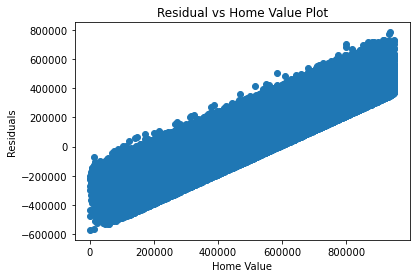

In [68]:
plot_residuals(zillow_lr.y, zillow_lr.yhat)

### regression_errors(y, yhat): returns the following values:
- sum of squared errors (SSE)
- explained sum of squares (ESS)
- total sum of squares (TSS)
- mean squared error (MSE)
- root mean squared error (RMSE)

In [63]:
def regression_errors(y, yhat):
    #Mean Squared Error
    MSE = mean_squared_error(y, yhat)
    #Sum of Squared Errors
    SSE = MSE2* len(y)
    #Root Mean Squared Errors (RMSE)
    RMSE = MSE**.5
    #Explained sum of squares
    ESS = ((yhat - y.mean())**2).sum()
    #Total sum of squares
    TSS = ESS + SSE
    return MSE, SSE, RMSE, ESS, TSS

In [72]:
regression_errors(zillow_lr.y, zillow_lr.yhat)

(32500492428.958134,
 233993577407.56415,
 180278.92952022466,
 9167428799614580.0,
 9167662793191988.0)

### baseline_mean_errors(y): computes the SSE, MSE, and RMSE for the baseline model:

In [70]:
def baseline_mean_errors(y):
    '''computes the SSE, MSE, and RMSE for the baseline model'''
    #Calculate Baseline
    baseline = np.repeat(y.mean(), len(y))
    #Computes SSE, MSE, RMSE
    MSE = mean_squared_error(y, baseline)
    SSE = MSE * len(y)
    RMSE = MSE **.5
    return SSE, MSE, RMSE

In [71]:
baseline_mean_errors(zillow_lr.y)

(5.135154044927293e+16, 39563482228.76555, 198905.71190583127)

### better_than_baseline(y, yhat): returns true if your model performs better than the baseline, otherwise false

In [73]:
def better_than_baseline(y,yhat):
    SSE, ESS, TSS, MSE, RMSE = regression_errors(y, yhat)
    SSE_baseline, MSE_baseline, RMSE_baseline = baseline_mean_errors(y)
    if MSE > MSE_baseline:
        print("My model performs better than baseline")
    else:
        print("My model performs worse than the baseline")

In [74]:
better_than_baseline(zillow_lr.y, zillow_lr.yhat)

My model performs better than baseline
